In [2]:
# Setup

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
from matplotlib.patches import Circle, ConnectionPatch
import matplotlib.animation as animation
from numpy.lib.stride_tricks import sliding_window_view
from scipy import integrate, spatial

from utils.plot.utils import plot_cobweb, get_iterative_map_results, plot_orbit_diagram

plt.rcParams["figure.figsize"] = (20, 20)

def saveFig(filename, chapter):
  plt.savefig(f"plots/chapter{chapter}/{filename}.png", facecolor="w")

# Chapter 11 - Fractals

A fractal is a geometric shape with fine structure at arbitrary scales, often exhibiting some degree of self-similarity

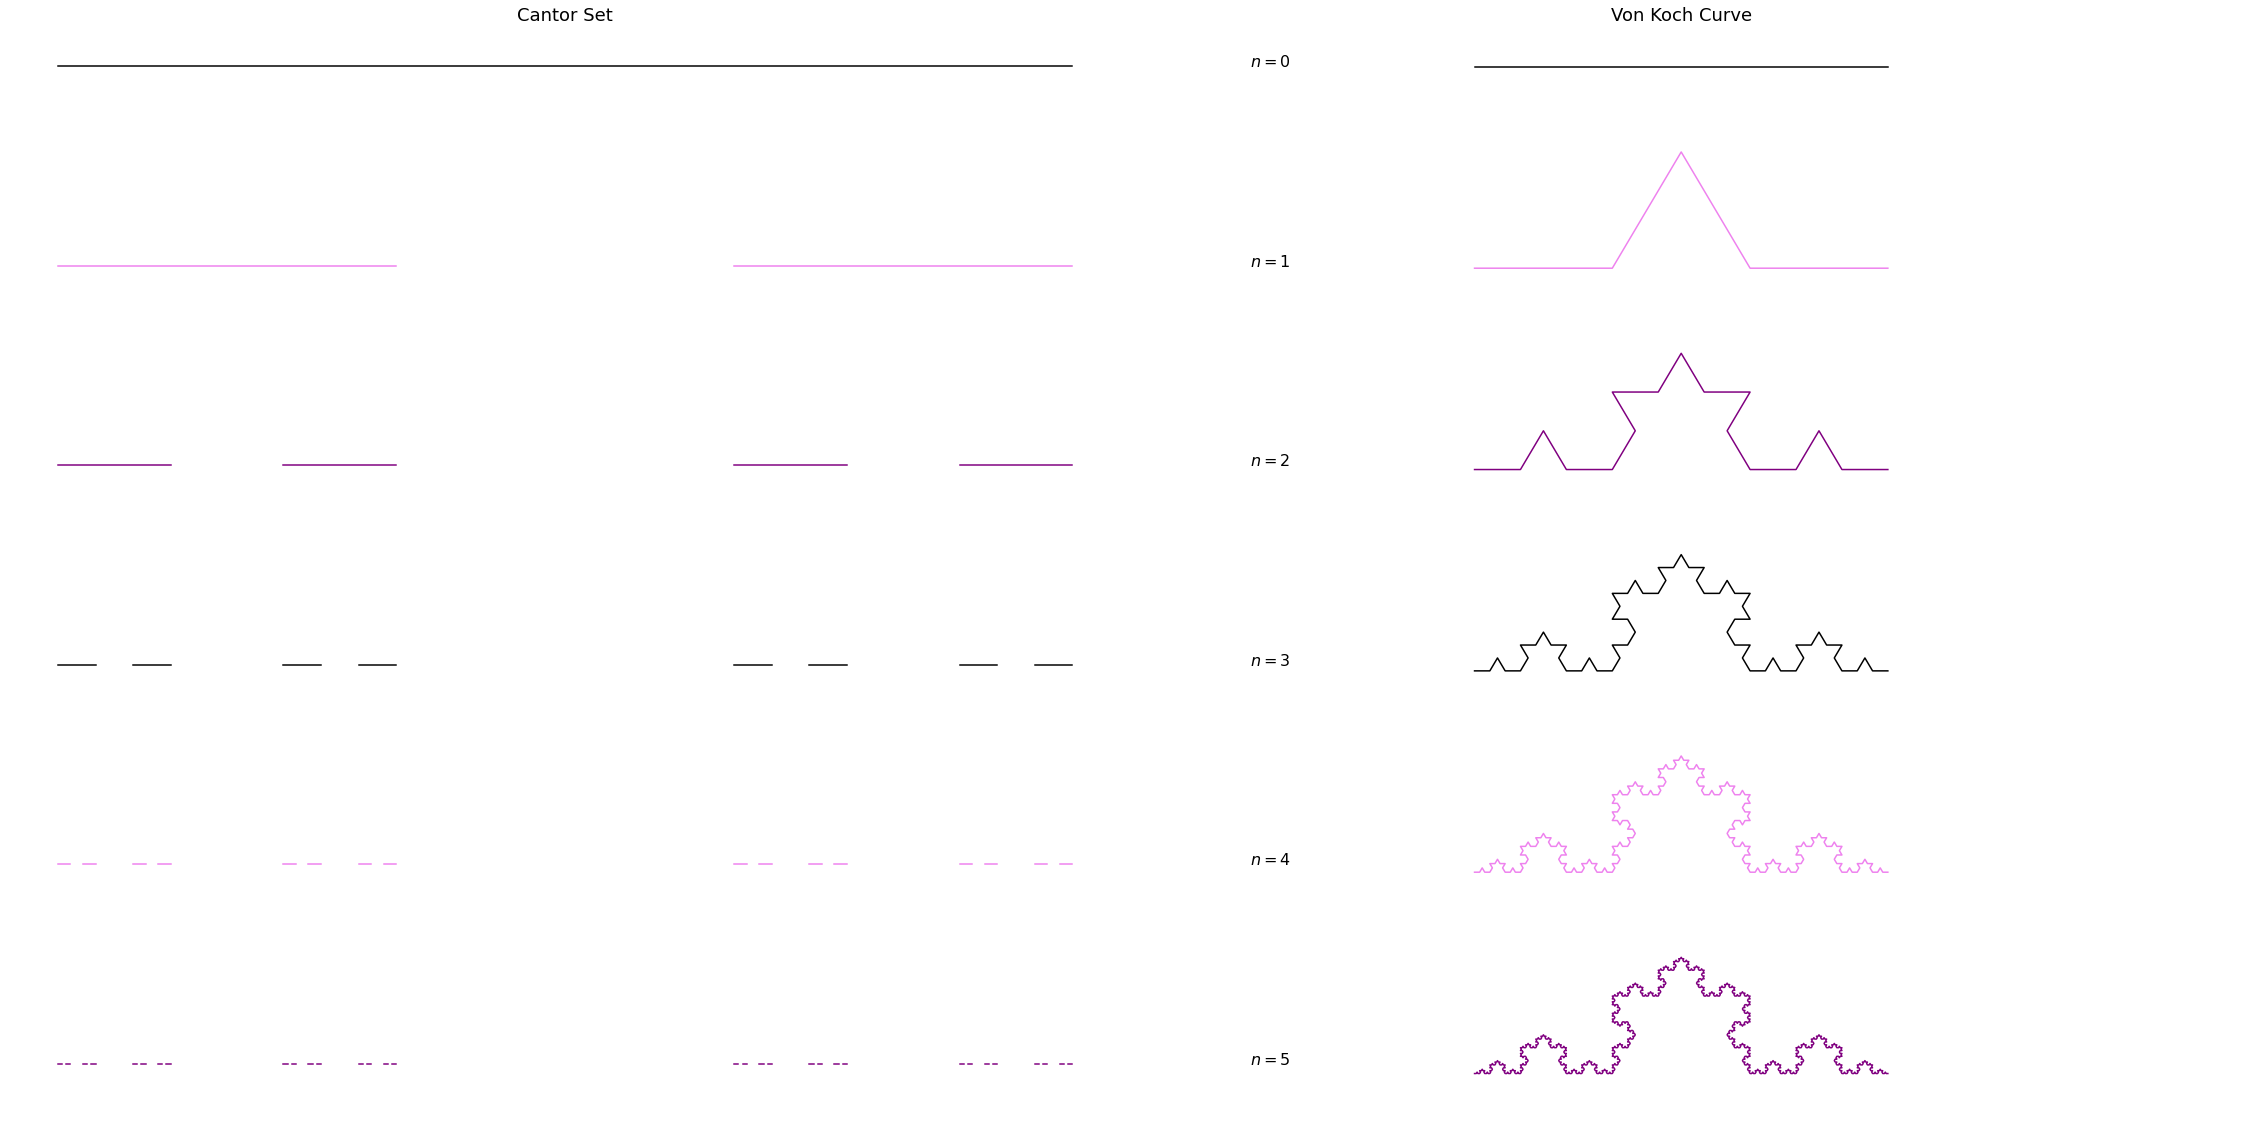

In [191]:
fig, (axA, axB) = plt.subplots(1, 2, figsize=(40, 20), gridspec_kw=dict(wspace=0))

def get_cantor_set(max_n):
  if max_n == 0:
    return np.array([0, 1])

  interval = get_cantor_set(max_n - 1)
  return np.concatenate((interval / 3, (interval + 2) / 3))

colors = ["black", "violet", "purple"]

for n in range(0, 6):
  for [a, b] in sliding_window_view(get_cantor_set(n), 2)[::2]:
    axA.plot([a, b], np.array([1, 1]) * -n, colors[n % len(colors)])

axA.set_ylim([-5.25, .2])
axA.axis("off")
axA.set_title("Cantor Set", fontsize=18)

def get_rotation_matrix(angle):
  return np.array([
    [np.cos(angle), -np.sin(angle)],
    [np.sin(angle), np.cos(angle)]
  ])

def get_koch_curve(max_n):
  if max_n == 0:
    return np.array([[0, 0], [1, 0]])
  
  curve = get_koch_curve(max_n - 1) / 3
  return np.concatenate([
    curve[:-1],
    np.array([np.dot(get_rotation_matrix(np.pi / 3), p) for p in curve]) + np.array([1/3, 0]),
    np.array([np.dot(get_rotation_matrix(-np.pi / 3), p) for p in curve])[:-1] + np.array([1/2, np.sqrt(3)/6]),
    curve + np.array([2/3, 0])
  ])

for n in range(0, 6):
  xs, ys = get_koch_curve(n).T
  axB.plot(xs - .5, ys - n / 2, colors[n % len(colors)])

axB.axis("off")
axB.set_ylim([-2.6, .1])
axB.set_xlim([-1.35, 1.35])
axB.set_title("Von Koch Curve", fontsize=18)

for n in range(0, 6):
  axA.text(1.175, -n, f"$n = {n}$", fontsize=16)

The Koch curve has infinite distance between any two distinct points, therefore it isn't one dimensional (as if it mapped to the 1D real line then the points would have a finite distance), but it doesn't enclose an area so it is less than two dimensional.
The dimensionality of a fractal can be defined in several different ways:
- **Similarity dimension**: Scale down the fractal by a factor of $r$ and let $m$ be the number of copies required to reconstruct the original, then $m = r^d$ where $d$ is the similarity dimension. Equivalently $d = \ln m / \ln r$
  - Easy to compute but only works for self similar fractals
- **Box dimension**: Let the minimum number of boxes of length $\epsilon$ required to cover the fractal be $N(\epsilon)$, then $N(\epsilon) \propto 1/\epsilon^d$. The box dimension $d$ is defined by $\lim_{\epsilon \to 0} \ln N(\epsilon) / \ln (1 / \epsilon)$
  - Can be difficult to compute
  - Leads to some nonsense results e.g. the rationals have a box dimension of 1 despite being countable
- **Pointwise dimension**: Pick a point $x$ on the shape, let $N(\epsilon)$ be the number of points within an open ball of radius $\epsilon$ about $x$, typically $N(\epsilon) \propto \epsilon^d$
  - Useful for computing the dimension for an attractor
  - Pointwise dimension can vary depending on the point picked
  - Provides a measure of how often trajectories pass near to $x$
  - Power law only holds when $\epsilon$ is within a certain range: It must be much larger than the typical spacing between points but much smaller than the size of the attractor
- **Correlation dimension**: The average of the pointwise dimension over many points
  - Gives an overal measure of the dimension for the whole geometry

The correlation dimension of the Lorenz attractor is $\approx 2.05$

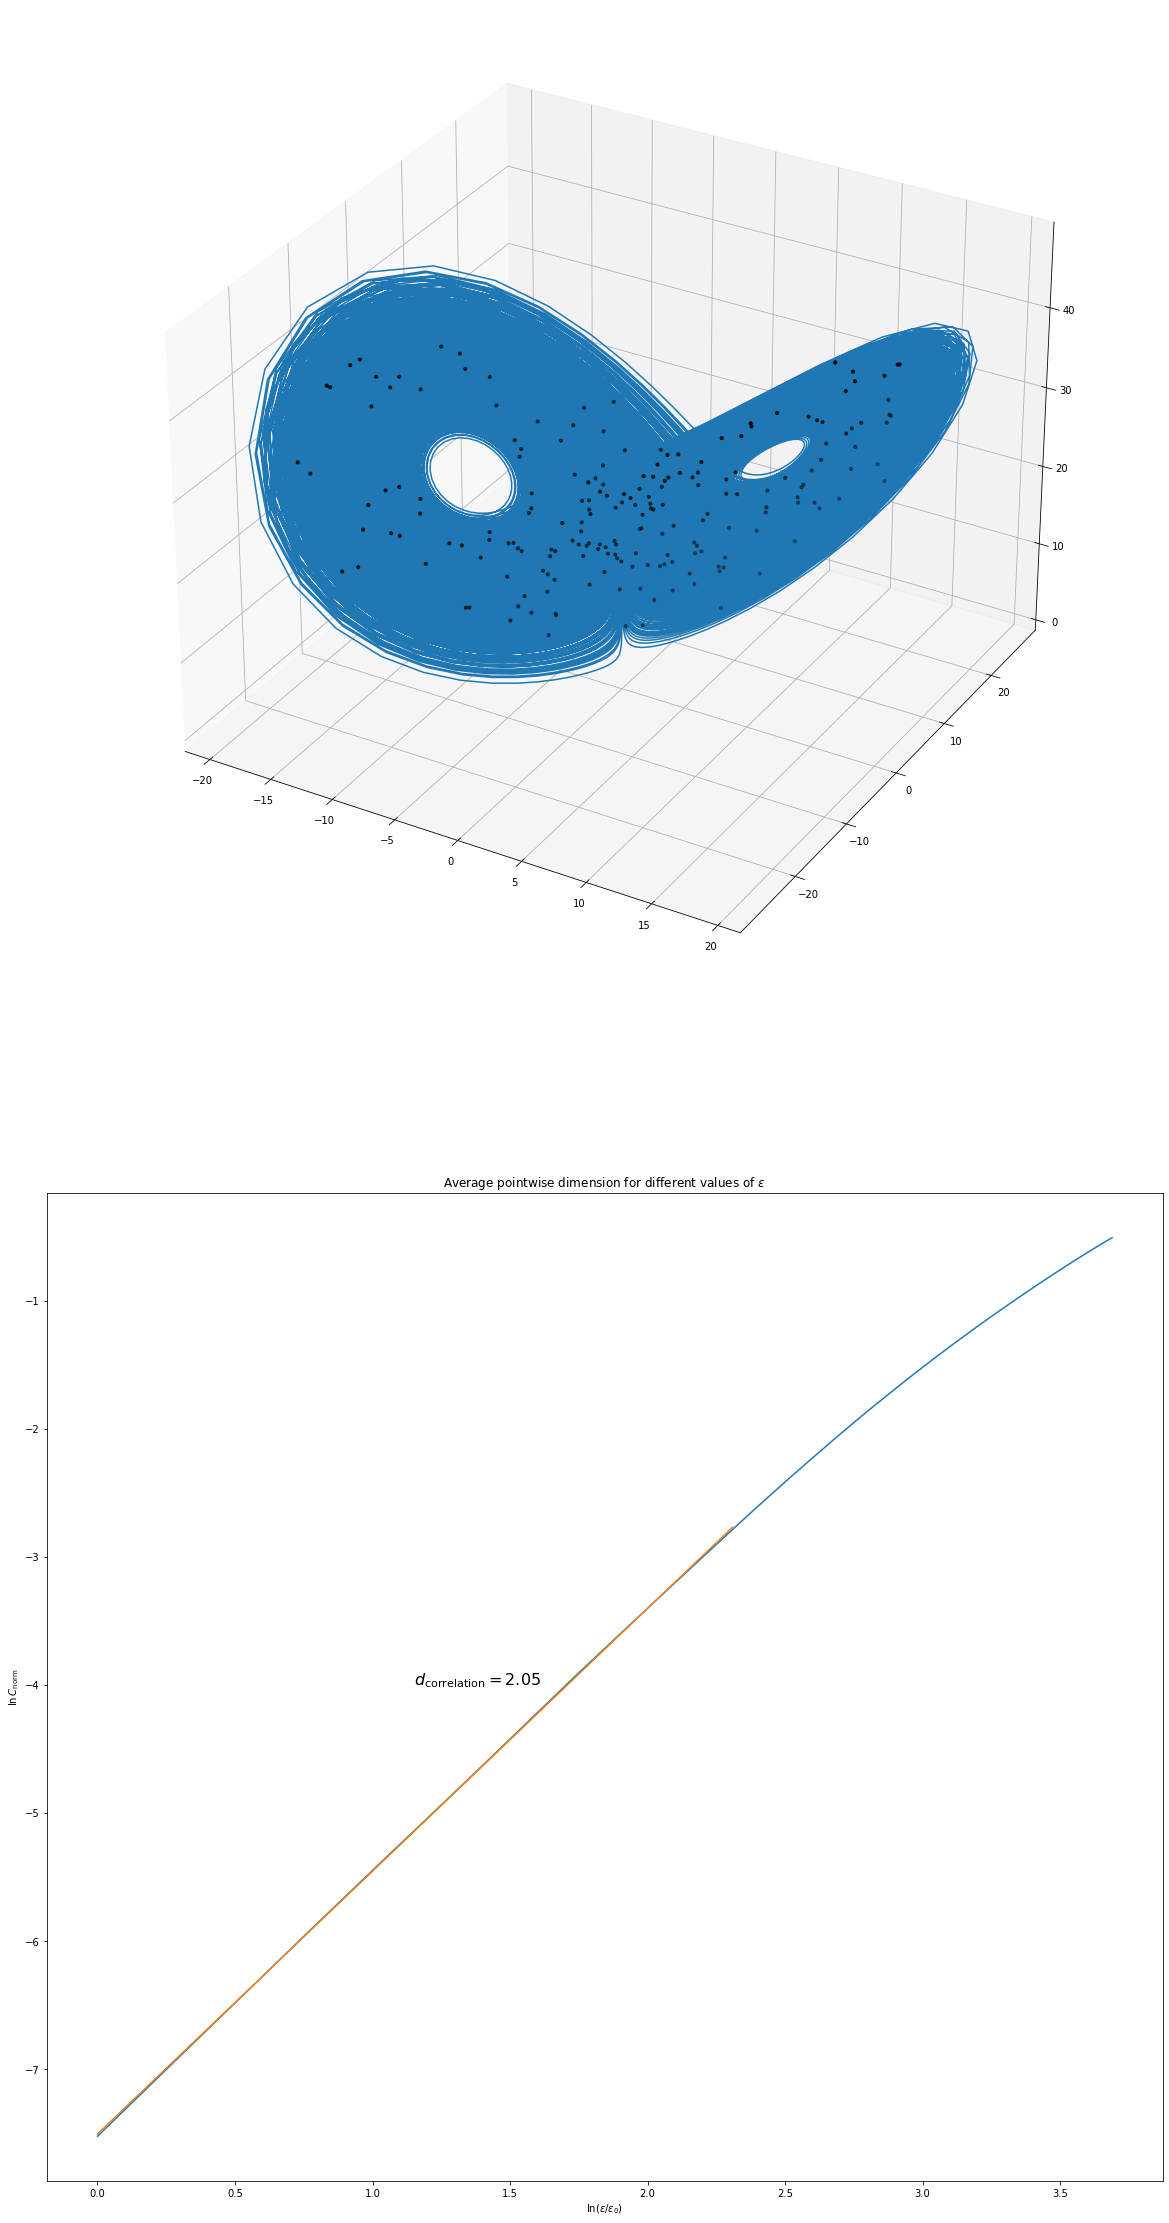

In [367]:
def lorenz(sigma, b, r):
  return lambda t, y: [sigma * (y[1] - y[0]), r * y[0] - y[1] - y[0] * y[2], y[0] * y[1] - b * y[2]]

sol = integrate.solve_ivp(lorenz(10, 8/3, 28), [0, 3000], [0, 1, 0], max_step=.02)

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(2, 1, 1, projection="3d")

ys = sol.y[:, 10000:]
y_points = ys.T

ax.plot(ys[0], ys[1], ys[2])

rng = np.random.default_rng(42)
ball_centers = rng.choice(ys, 200, axis=1)
ax.scatter(*ball_centers, color="black", s=10)

epsilons = np.linspace(.5, 20, 100)
Cs = np.zeros_like(epsilons)

for x in ball_centers.T:
  distance_to_points = spatial.distance_matrix(y_points, x.reshape(1,3))
  Cs += np.array([len(np.extract(distance_to_points < epsilon, distance_to_points)) for epsilon in epsilons])

Cs /= len(ball_centers.T)

epsilon_cuttoff = 5
cuttoff_index = np.argwhere(epsilons > epsilon_cuttoff)[0, 0]
log_epsilons = np.log(epsilons / epsilons[0])
log_cs = np.log(Cs / len(y_points))
correlation_dim, c = np.polyfit(log_epsilons[:cuttoff_index], log_cs[:cuttoff_index], 1)
xs = np.linspace(log_epsilons[0], log_epsilons[cuttoff_index], 2)

ax = fig.add_subplot(2, 1, 2)
ax.plot(log_epsilons, log_cs)
ax.plot(xs, correlation_dim * xs + c)
ax.text(1.15, -4, f"$d_{{\\mathrm{{correlation}}}} = {round(correlation_dim, 2)}$", fontsize=16)
ax.set_xlabel("$\ln(\epsilon / \epsilon_0)$")
ax.set_ylabel("$\ln C_\\mathrm{norm}$")
ax.set_title("Average pointwise dimension for different values of $\epsilon$")

plt.show()

## Exercises

### 11.3.8-11.3.9
Sierpinski carpet ($N=2$), Menger sponge ($N=3$) etc. have similarity dimension $\ln(3^N - 1)/\ln 3$. Note that they are extensions of the Cantor set to $N$ dimensions, also note that the cross section of a Sierpinski carpet is a topological Cantor set (with the middle cross section giving the middle-thirds Cantor set), the cross section of a Menger sponge is similarly a Sierpinski carpet etc.

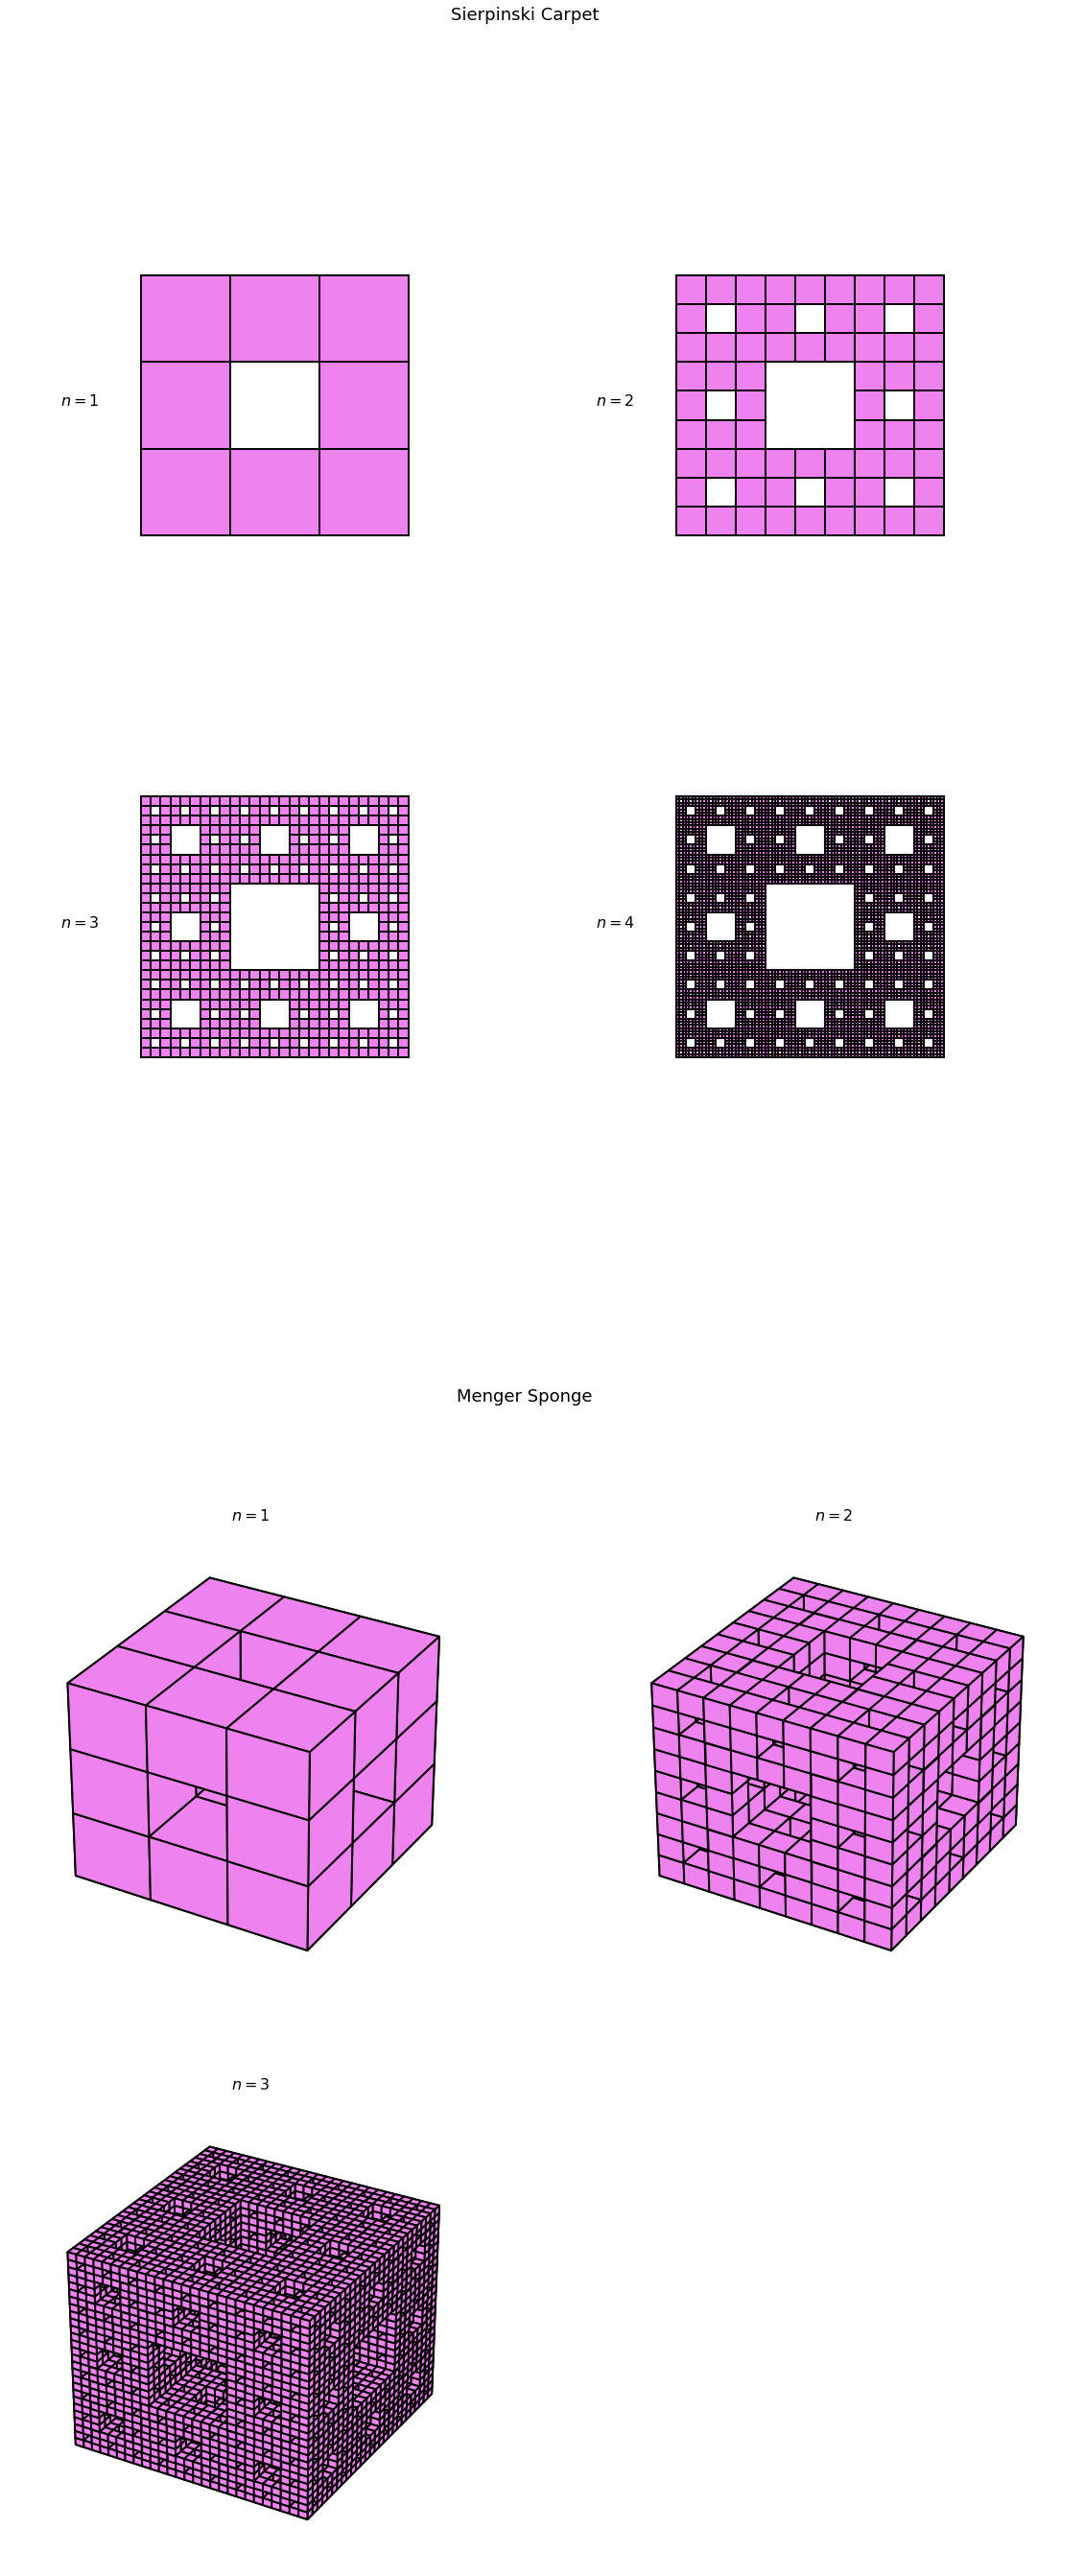

In [187]:
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(20, 40))
figA, figB = fig.subfigures(2, 1)
axA = figA.add_subplot(1, 1, 1)

offsets = [np.array(offset) for offset in [
  [-1/3, 1/3],
  [0, 1/3],
  [1/3, 1/3],
  [-1/3, 0],
  [1/3, 0],
  [1/3, -1/3],
  [0, -1/3],
  [-1/3, -1/3],
]]
def plot_sierpinski_carpet(ax: plt.Axes, n, scale=1, center=np.array([0, 0])):
  if n == 0:
    return ax.add_patch(Rectangle((center[0] - scale / 2, center[1] - scale / 2), scale, scale, facecolor="violet", edgecolor='black', linewidth=2))

  for offset in offsets:
    plot_sierpinski_carpet(ax, n - 1, scale / 3, center + offset * scale)

for n, center in enumerate([
    np.array([-.5, .5]),
    np.array([.5, .5]),
    np.array([-.5, -.5]),
    np.array([.5, -.5]),
  ], start=1):
  axA.text(*(center + np.array([-.4, 0])), f"$n = {n}$", fontsize=16)
  plot_sierpinski_carpet(axA, n, scale=.5, center=center)
axA.set_xlim([-1, 1])
axA.set_ylim([-1, 1])
axA.axis("off")
figA.suptitle("Sierpinski Carpet", fontsize=18)

def menger_center_predicate(axis_indices, n):
  """
  Sets the indices that are removed in the nth iteration of the Menger sponge to false.
  This is equivalent to expanding the value of the index / num indices in axis (3 ** n), multiplying by 3 to move the digit to the left,
  then checking if the most significant digit is not 1 (mod 3 as for sub-sponges they are repeated). Applying this for all values of n
  is equivalent to checking that the base-3 expansion doesn't contain any 1s in each direction
  """
  return np.floor(axis_indices / 3 ** (n-1)) % 3 != 1

def plot_menger_sponge(ax: plt.Axes, n, anchor = np.array([0, 0, 0])):
  x, y, z = np.indices((3 ** n, 3 ** n, 3 ** n))
  voxel_array = np.all([
    (menger_center_predicate(x, i) | menger_center_predicate(y, i)) &
    (menger_center_predicate(x, i) | menger_center_predicate(z, i)) &
    (menger_center_predicate(y, i) | menger_center_predicate(z, i))
    for i in range(1, n + 1)
  ], axis=0)
  ax.voxels(voxel_array, facecolor="violet", edgecolor='black', linewidth=2)

figB.suptitle("Menger Sponge", fontsize=18)

for n in range(1, 4):
  ax = figB.add_subplot(2, 2, n, projection="3d")
  plot_menger_sponge(ax, n)
  ax.axis("off")
  ax.set_title(f"$n = {n}$", fontsize=16)

plt.show()